Проект команды paranormal в рамках домашнего задания Летней Школы МТС.Тета, направление "Машинное обучение"

#### Загрузка необходимых библиотек

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, accuracy_score, f1_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
import pickle # для загрузки и сохранения модели
import warnings
warnings.filterwarnings('ignore')

#### Настройка цветовой схемы

In [2]:
sns.set_theme(style='whitegrid', palette='deep',)

## 1. EDA

### 1.1. Предобработка датасета

In [3]:
# загрузка данных
data = pd.read_csv('data/diabetes.csv')
# убираем дубликаты
data = data.drop_duplicates()
# провидим в однообразное написание название переменных
data.rename(str.lower, axis='columns', inplace=True)
# заменяем значения 'Female', 'No' и 'Negative' на 0, 'Male', 'Yes' и 'Positive' - на 1
data = data.replace(["Yes", 'No', 'Male', 'Female', 'Positive', 'Negative'], [1, 0, 1, 0, 1, 0])
# сохраняем загруженные данные в отдельный датасет
df_diabetes = data.copy()
# переименовываем переменные - замена пробела на _
print("Переменные до изменения: ", df_diabetes.columns.to_list())
df_diabetes.columns = (['age', 'gender',  'polyuria',  'polydipsia', 'sudden_weight_loss',
                        'weakness', 'polyphagia', 'genital_thrush', 'visual_blurring',
                        'itching', 'irritability', 'delayed_healing', 'partial_paresis',
                        'muscle_stiffness', 'alopecia', 'obesity','class'])
print("Переменные после изменения: ", df_diabetes.columns.to_list())
df_diabetes.head(5)

Переменные до изменения:  ['age', 'gender', 'polyuria', 'polydipsia', 'sudden weight loss', 'weakness', 'polyphagia', 'genital thrush', 'visual blurring', 'itching', 'irritability', 'delayed healing', 'partial paresis', 'muscle stiffness', 'alopecia', 'obesity', 'class']
Переменные после изменения:  ['age', 'gender', 'polyuria', 'polydipsia', 'sudden_weight_loss', 'weakness', 'polyphagia', 'genital_thrush', 'visual_blurring', 'itching', 'irritability', 'delayed_healing', 'partial_paresis', 'muscle_stiffness', 'alopecia', 'obesity', 'class']


,age,gender,polyuria,polydipsia,sudden_weight_loss,weakness,polyphagia,genital_thrush,visual_blurring,itching,irritability,delayed_healing,partial_paresis,muscle_stiffness,alopecia,obesity,class
0,40,1,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1
1,58,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1
2,41,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1
3,45,1,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1
4,60,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1


#### Переменные:
- polyuria - полиурия (увеличенное образование мочи)
- polydipsia - полидипсия (неутолимая жажда)
- sudden weight loss - внезапная потеря веса
- weakness - слабость
- polyphagia - полифагия (повышенный аппетит)
- genital thrush - генитальная молочница
- visual blurring - расплывчатость зрения
- itching - зуд
- irritability - раздражительность
- delayed healing - медленное заживление ран
- partial paresis - частичный парез (потеря мышечной силы)
- muscle stiffness - жесткость мышц
- alopecia - алопеция (выпадение волос)
- obesity - ожирение

### 2.2. Разведочный анализ данных

In [4]:
print('Уникальные значения переменных')
for col in df_diabetes.columns:
    print(col, df_diabetes[col].unique())
print('')
df_diabetes.info()

Уникальные значения переменных
age [40 58 41 45 60 55 57 66 67 70 44 38 35 61 54 43 62 39 48 32 42 52 53 37
 49 63 30 50 46 36 51 59 65 25 47 28 68 56 31 85 90 72 69 79 34 16 33 64
 27 29 26]
gender [1 0]
polyuria [0 1]
polydipsia [1 0]
sudden_weight_loss [0 1]
weakness [1 0]
polyphagia [0 1]
genital_thrush [0 1]
visual_blurring [0 1]
itching [1 0]
irritability [0 1]
delayed_healing [1 0]
partial_paresis [0 1]
muscle_stiffness [1 0]
alopecia [1 0]
obesity [1 0]
class [1 0]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 251 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   age                 251 non-null    int64
 1   gender              251 non-null    int64
 2   polyuria            251 non-null    int64
 3   polydipsia          251 non-null    int64
 4   sudden_weight_loss  251 non-null    int64
 5   weakness            251 non-null    int64
 6   polyphagia          251 non-null   

<div class="alert alert-block alert-info"><b>
Пропущенных значений нет, нет необходимости в обработке пропусков
</div> 

In [5]:
df_diabetes.describe()

,age,gender,polyuria,polydipsia,sudden_weight_loss,weakness,polyphagia,genital_thrush,visual_blurring,itching,irritability,delayed_healing,partial_paresis,muscle_stiffness,alopecia,obesity,class
count,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000
mean,48.864542,0.637450,0.525896,0.494024,0.414343,0.633466,0.466135,0.266932,0.442231,0.505976,0.282869,0.498008,0.446215,0.390438,0.358566,0.175299,0.689243
std,12.526036,0.481697,0.500327,0.500963,0.493592,0.482820,0.499849,0.443241,0.497644,0.500963,0.451293,0.500995,0.498092,0.488823,0.480538,0.380982,0.463728
min,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,39.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,48.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,58.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,90.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<div class="alert alert-block alert-info"><b>
    <p>В датасете данные пациентов в возрасте от 16 до 90 лет, медиана - 48 лет, средний 48.9 лет. </p>
    <p>Остальные переменные - бинарные. </p>
    <p>Датасет по целевому классу достаточно сбалансирован: 69% на 31%.
</div> 

<AxesSubplot:xlabel='age', ylabel='Density'>

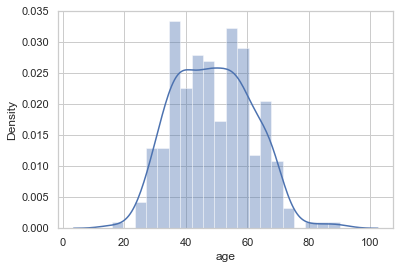

In [6]:
palette = sns.color_palette("rocket_r")
sns.distplot(df_diabetes['age'], bins=20)

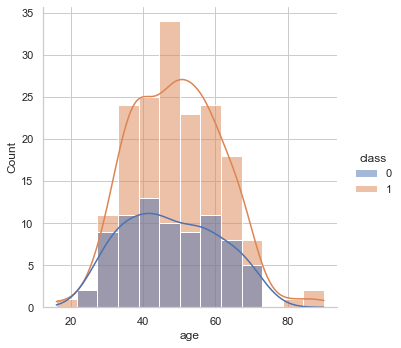

In [7]:
sns.displot(data=data, x='age', hue='class', kde = True);

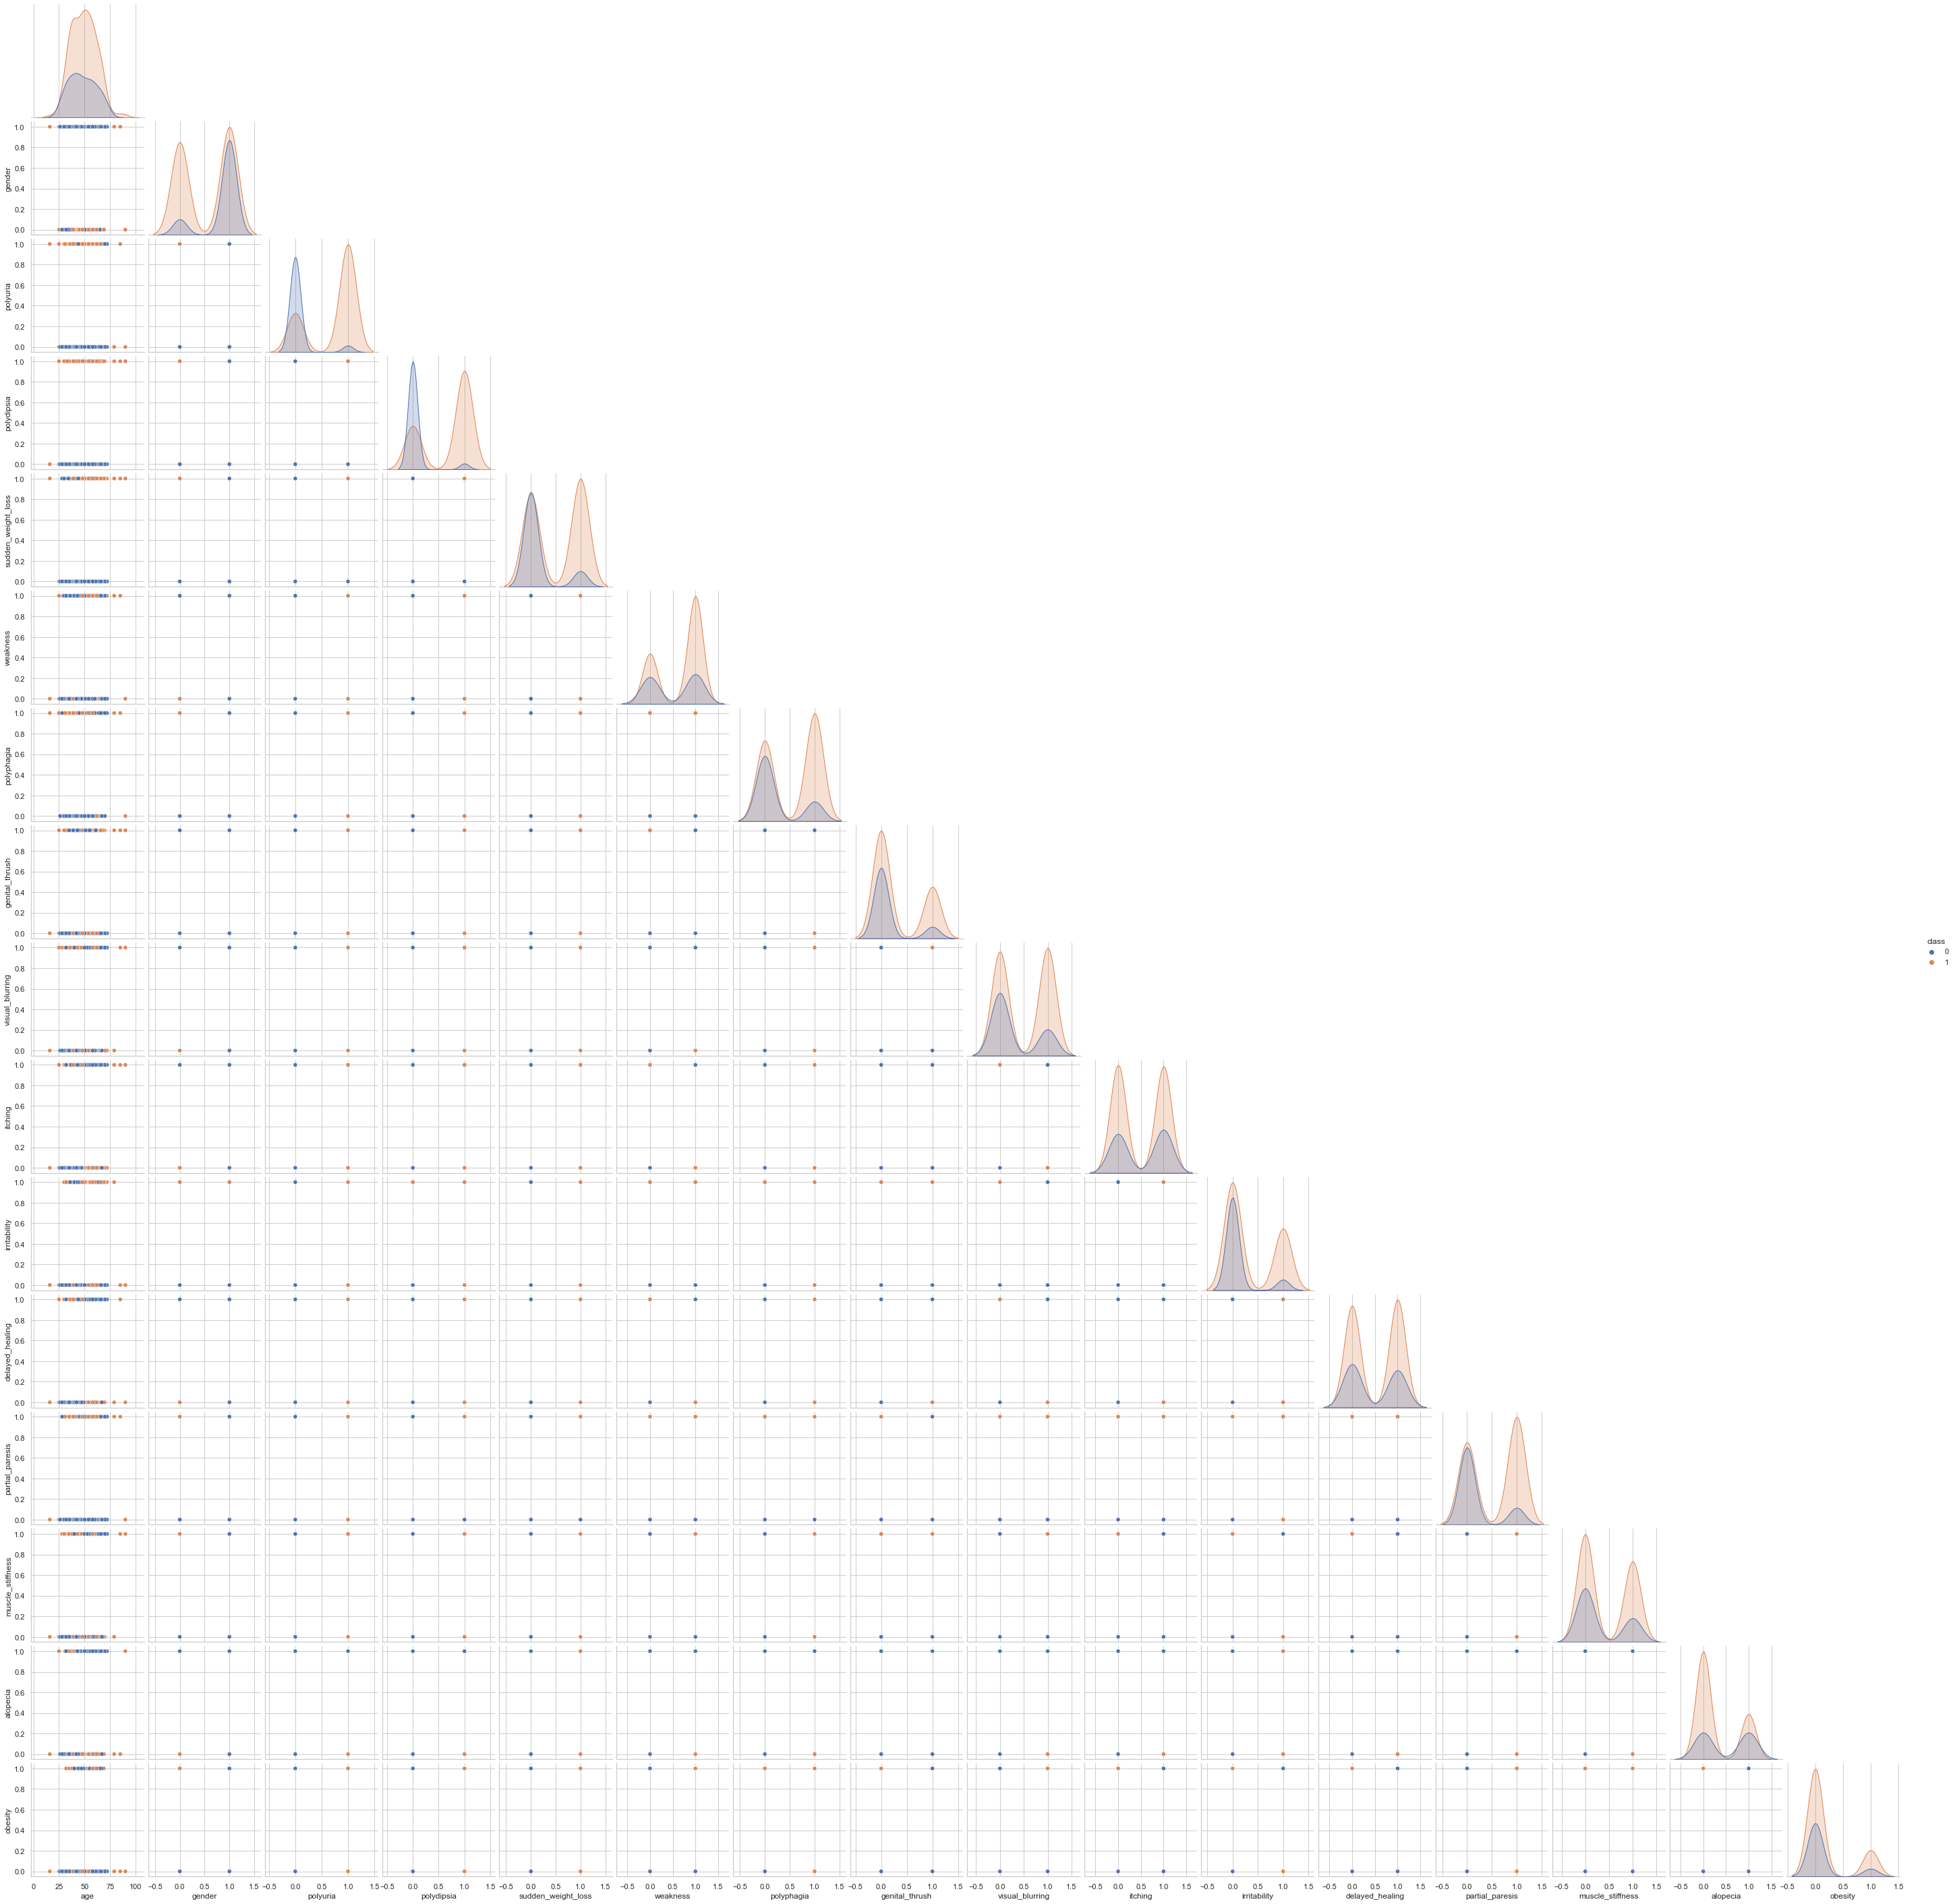

In [8]:
sns.pairplot(df_diabetes, hue='class', corner=True)

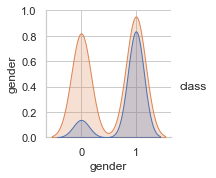

In [9]:
sns.pairplot(df_diabetes[['gender', 'class']], hue='class')

In [10]:
round(df_diabetes[df_diabetes['class'] == 1].groupby(['gender'])['weakness'].count() / df_diabetes[df_diabetes['class'] == 1]['weakness'].count() * 100, 2)

gender
0    46.24
1    53.76
Name: weakness, dtype: float64

<AxesSubplot:>

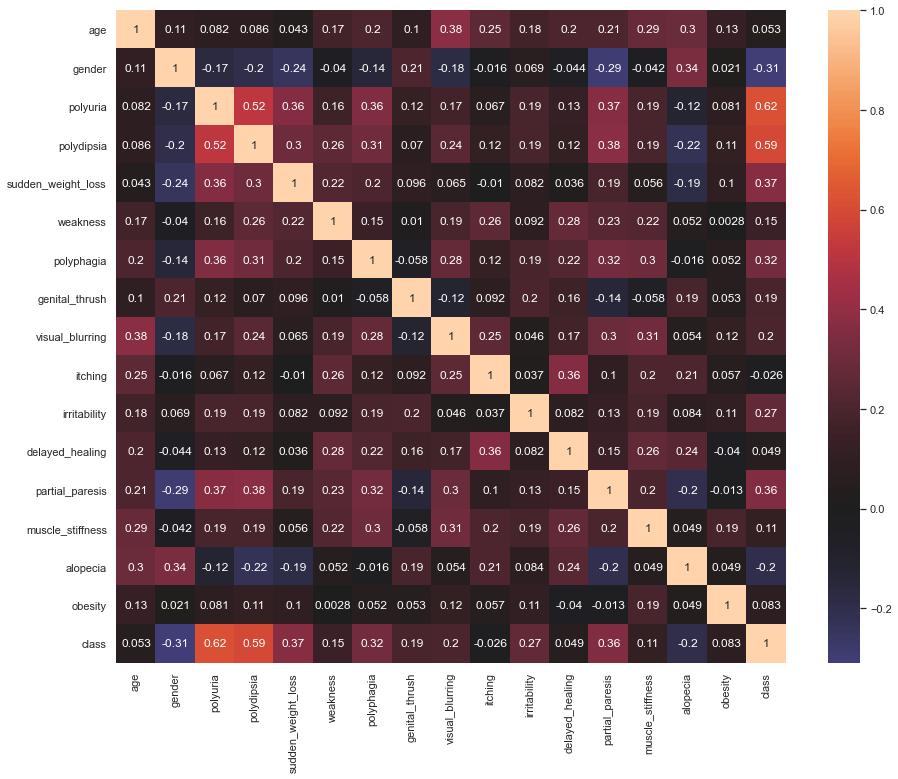

In [11]:
fig, ax = plt.subplots(figsize=(15,12))   
sns.heatmap(df_diabetes.corr(method='pearson'), center=0, square=False, annot=True, ax=ax)

In [12]:
from scipy.stats import pointbiserialr
pointbiserialr(df_diabetes.iloc[:, 1], df_diabetes.age)

PointbiserialrResult(correlation=0.10916809206933129, pvalue=0.0843335297777791)

<div class="alert alert-block alert-info"><b>
    Основные выводы
</div> 

<div class="alert alert-block alert-info"><b>
    
1) Диабет, особенно 2-го типа, наиболее распространен среди мужчин, чем среди женщин. https://www.news-medical.net/health/Diabetes-in-Men-versus-Women.aspx

2) Целевой класс сильно коррелирует с переменными полиурия и полидипсия.  https://www.jdrf.org/t1d-resources/about/symptoms/frequent-urination/

3) Также целевой класс коррелирует с внезапной потерей веса. https://www.medicinenet.com/is_weight_loss_caused_by_diabetes_dangerous/ask.htm

4) Перечисленные в исходных данных признаки (полиурия, полидипсия, внезапная потеря веса, слабость, повышенный аппетит, ожирание, зуд и т.п.) являются симптомами сахарного диабета.  Стоит отметить, что чем выше стадия сахарного диабета, тем заметнее проявление симптомов. 

5) Указан признак полиурия, но помимо этого возможно также ночное недержание. Можно добавить и такие признаки, как онемение и покалывание в руках и ногах, повышеная потливость, быстрая утомляемость, нехватка энергии, сильная усталость и сухость во рту из-за чувства жажды.

6) На представленных данных можно построить модель. В будущем в данные можно будет добавить указанные выше симптомы, а также расширить географию сбора данных.

7) Признаки не противоречат друг другу, данные соответствуют гипотезе.

</div> 

## 2. Modelling

In [13]:
rdm_state = 42
param_grid = {
    'n_estimators': np.arange(5, 51, 15),
    'max_depth': np.arange(5, 51, 15),
    'min_samples_split': np.arange(2, 11, 4),
    'min_samples_leaf': np.arange(1, 10, 4),
    'max_samples': np.arange(0.1, 0.99, 0.23), 
}
cv = 3

In [14]:
X = df_diabetes.drop('class', 1)
y = df_diabetes['class']

In [15]:
(X_train, X_test, 
 y_train, y_test) = train_test_split(X, y, 
                                     test_size=0.25, 
                                     random_state=rdm_state, shuffle=True)

<div class="alert alert-block alert-info"><b>
    Решая поставленную задачу, мы испробовали несколько методов машинного обучения, такие как логистическая регрессия, SVM, random forest. Лучший результат на наших данных показал случайный лес по F1. Приводим код только финальной модели.</div> 

#### Random forest

In [16]:
%%time
model_RFC = RandomForestClassifier(n_jobs=-1, random_state=rdm_state)
clf = GridSearchCV(model_RFC, param_grid, cv=cv)
clf.fit(X_train, y_train)
clf.best_params_

Wall time: 5min 32s


{'max_depth': 20,
 'max_samples': 0.56,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 35}

In [17]:
y_pred_RFC = clf.predict(X_test)

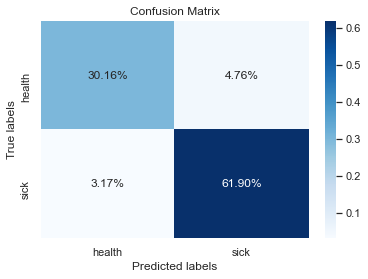

In [18]:
conf_mat = confusion_matrix(y_test, y_pred_RFC)

ax = plt.subplot()
sns.heatmap(conf_mat/np.sum(conf_mat), annot=True, 
            fmt='.2%', cmap='Blues', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['health', 'sick']); ax.yaxis.set_ticklabels(['health', 'sick']);

In [19]:
print(f'f1 score - {round(100 * f1_score(y_test, y_pred_RFC), 2)}%,\nrecall score - {round(100* recall_score(y_test, y_pred_RFC), 2)}%')

f1 score - 93.98%,
recall score - 95.12%


<div class="alert alert-block alert-info"><b>
    Полученное значение F1 меры соответствует ожидаемому качеству модели. </div> 

## 3. Сохраняем модель

In [20]:
clf

GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             param_grid={'max_depth': array([ 5, 20, 35, 50]),
                         'max_samples': array([0.1 , 0.33, 0.56, 0.79]),
                         'min_samples_leaf': array([1, 5, 9]),
                         'min_samples_split': array([ 2,  6, 10]),
                         'n_estimators': array([ 5, 20, 35, 50])})

In [21]:
# Save to file in the current working directory
pkl_filename = "random_forest_diabet.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf, file)

## 4. Загрузка модели для сверки

In [22]:
# Load from file
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)
    
# Calculate the accuracy score and predict target values
score = pickle_model.score(X_test, y_test)
print("Test score: {0:.2f} %".format(100 * score))
Ypredict = pickle_model.predict(X_test)

Test score: 92.06 %


In [23]:
y_pred_RFC = pickle_model.predict(X_test)